In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv', index_col=0)
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv', index_col=0)

x_val = pd.read_csv('../no_nontoxic_nans_X_val.csv', index_col=0)
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv', index_col=0)

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv', index_col=0)
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv', index_col=0)


In [3]:
RFC = RandomForestClassifier(n_estimators=100, criterion='gini')
RFC_model = RFC.fit(x_train,y_train)

def model_metrics(x_data, y_data, model):
    model_prediction = model.predict(x_data)
    accuracy_prediciton = metrics.accuracy_score(y_data, model_prediction)
    print('accuracy:', accuracy_prediciton)


c:\Users\dx21006\.conda\envs\chem-ml-env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [4]:
model_metrics(x_train, y_train, RFC_model)
model_metrics(x_val, y_val, RFC_model)
model_metrics(x_test, y_test, RFC_model)

accuracy: 0.9989162828501761
accuracy: 0.7840909090909091
accuracy: 0.8156565656565656


In [5]:
def get_confusion_matrix(x_data, y_data, model, train_test_val_type):
    print('Confusion Matrix for', train_test_val_type, 'data')
    model_prediction = model.predict(x_data)
    ConfusionMatrixDisplay.from_predictions(y_data, model_prediction);

Confusion Matrix for training data
Confusion Matrix for validation data
Confusion Matrix for test data


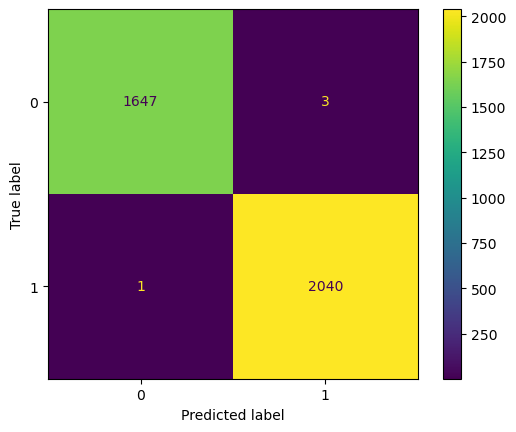

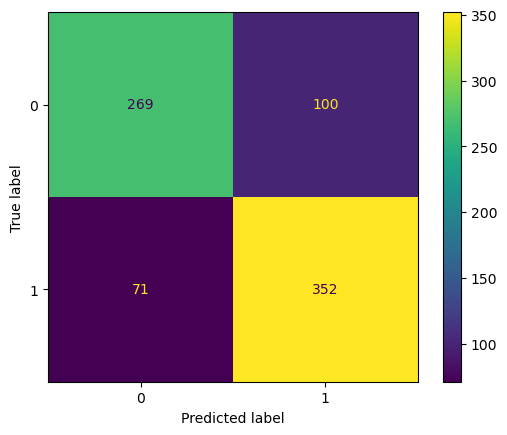

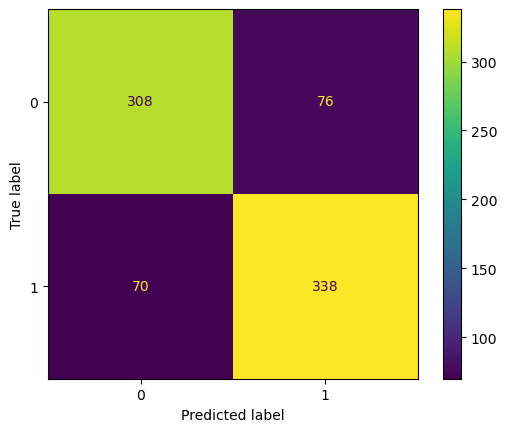

In [6]:
get_confusion_matrix(x_train, y_train, RFC_model, 'training') 
get_confusion_matrix(x_val, y_val, RFC_model, 'validation') 
get_confusion_matrix(x_test, y_test, RFC_model, 'test') 

# Feature Importance Experiment
By Matt. Try and get some interesting histograms out of this?? Using this model because my NN one is shite.
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
#

In [22]:
#This is impurity based feature importance, apparently this is bad, using permutation based instead below
RFC_importances_impurity = pd.DataFrame(RFC_model.feature_importances_)
RFC_importances_impurity['feature'] = x_train.columns
RFC_importances_impurity

,0,feature
0,0.009916,MaxAbsEStateIndex
1,0.008187,MaxEStateIndex
2,0.009303,MinAbsEStateIndex
3,0.010138,MinEStateIndex
4,0.011404,qed
...,...,...
212,0.000211,fr_thiazole
213,0.000073,fr_thiocyan
214,0.000100,fr_thiophene
215,0.001525,fr_unbrch_alkane


In [28]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
RFC_importances_permutation = RFC_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
RFC_importances_permutation = pd.DataFrame(RFC_importances_permutation)
RFC_importances_permutation['feature'] = x_train.columns
RFC_importances_permutation

Elapsed time to compute the importances: 0.007 seconds


,0,feature
0,0.009916,MaxAbsEStateIndex
1,0.008187,MaxEStateIndex
2,0.009303,MinAbsEStateIndex
3,0.010138,MinEStateIndex
4,0.011404,qed
...,...,...
212,0.000211,fr_thiazole
213,0.000073,fr_thiocyan
214,0.000100,fr_thiophene
215,0.001525,fr_unbrch_alkane


our top 10 most important features according to permutation

In [39]:
top_10_RFC_importances_permutation = RFC_importances_permutation.nlargest(10, 0)
top_10_RFC_importances_permutation

,0,feature
130,0.025138,MolLogP
28,0.024099,BertzCT
22,0.020564,BCUT2D_LOGPHI
38,0.018865,Chi3v
46,0.018840,LabuteASA
68,0.017173,SMR_VSA7
6,0.017018,MolWt
26,0.016160,AvgIpc
129,0.015220,RingCount
7,0.015211,HeavyAtomMolWt


In [40]:
top_10_RFC_importances_impurity = RFC_importances_impurity.nlargest(10,0)
top_10_RFC_importances_impurity

,0,feature
130,0.025138,MolLogP
28,0.024099,BertzCT
22,0.020564,BCUT2D_LOGPHI
38,0.018865,Chi3v
46,0.018840,LabuteASA
68,0.017173,SMR_VSA7
6,0.017018,MolWt
26,0.016160,AvgIpc
129,0.015220,RingCount
7,0.015211,HeavyAtomMolWt


interestingly, the data is the same using both feature importance methods. Just use permutatioin because apparently it's better?

# Finding the worse functional groups

In [46]:
RFC_importance_perm_FG = RFC_importances_permutation[RFC_importances_permutation['feature'].str.contains("fr_")] #new df containing only the features called fr_, i.e. the functional groups
RFC_importance_perm_FG_top_10 = RFC_importance_perm_FG.nlargest(20,0)
RFC_importance_perm_FG_top_10

,0,feature
161,0.003630,fr_aniline
166,0.003270,fr_benzene
197,0.003140,fr_phenol
139,0.003027,fr_Ar_OH
198,0.002470,fr_phenol_noOrthoHbond
147,0.002109,fr_NH0
173,0.001943,fr_ether
168,0.001801,fr_bicyclic
158,0.001774,fr_allylic_oxid
215,0.001525,fr_unbrch_alkane


is this looking at just the most toxic compounds? Or what contributes most to overall score? ie could include non-toxic ones that lead to a definite non-toxic result

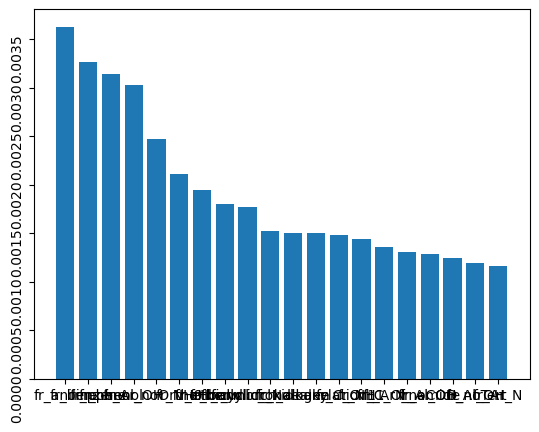

In [57]:
plt.bar(RFC_importance_perm_FG_top_10['feature'], RFC_importance_perm_FG_top_10[0])
plt.yticks(rotation='vertical')
plt.show()